In [22]:
#Import packages

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import math
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import linear_model, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.svm.libsvm import cross_validation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import scipy.stats
import numpy
from random import sample
import random
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_excel("data_stedin_excel_min.xlsx")
data = data[data['aangepakt'] == data['aangepakt']]

In [7]:
rep_data_opp = pd.read_csv("verbruik_data_met_oppervlakte.csv")
rep_data_opp = rep_data_opp[rep_data_opp['aangepakt'] == rep_data_opp['aangepakt']]

In [28]:
def dataPrep(data, iv, kleine_c, energyType, rep_data_opp, oppervlakte):
    
    data = data[data[energyType] == data[energyType]]
    rep_data_opp = rep_data_opp[rep_data_opp[energyType] == rep_data_opp[energyType]]
    
    dict_opp = pd.Series(rep_data_opp.oppervlakte.values,index=rep_data_opp.CLUST).to_dict()
    
    if oppervlakte == 1:
        data = data[data['categorie_match'] == 'PC6']
        
    if kleine_c == 1:
        data = data[data['groepsgrootte'] < 20]
    
    X = data.copy()
    
    y_column = [energyType]
    x_columns = ["woningtype_naam", "woningtype_bouwperiode", "woningtype_daktype", "aangepakt"]
    
    X = data[x_columns]
    X = pd.get_dummies(X)
    y = data[y_column]
    
    if (kleine_c == 1) and (oppervlakte == 1):
        X['Detached'] = 0
        cols = ['Retrofitted', 'Semi-detached', 'Apartment', 'Corner_house', 'Town_house', '1945-1964', '1965-1974', '1975-1991', '1991-2005', '2006-', '-1945', 'Flat_roof', 'Sloped_roof', 'Detached']
        X.columns = cols
        cols = ['Retrofitted', 'Apartment', 'Semi-detached', 'Detached', 'Corner_house', '-1945','1945-1964', '1965-1974', '1991-2005', '2006-']
        X = X[cols]
    else:
        cols = ['Retrofitted', 'Semi-detached', 'Apartment', 'Corner_house', 'Town_house', 'Detached', '1945-1964', '1965-1974', '1975-1991', '1991-2005', '2006-', '-1945', 'Flat_roof', 'Sloped_roof']
        X.columns = cols
        cols = ['Retrofitted', 'Apartment', 'Semi-detached', 'Detached', 'Corner_house', '-1945','1945-1964', '1965-1974', '1991-2005', '2006-']
        X = X[cols]
        
    columns = list(X.columns)
    
    if iv == 1:
        temp = []
        temp2 = []

        for i in columns:
            for j in columns:
                if j not in temp2:
                    temp.append([i,j])
            temp2.append(i)
            
        columns2 = columns.copy()

        for i in temp:
            columns2.append(i)
            
        for i in columns2:
            if len(i) == 2:
                X[i[0] + ' x ' + i[1]] = X[i[0]] * X[i[1]]

    X = pd.DataFrame(X)
    
    if oppervlakte == 1:
        X = pd.concat([X, rep_data_opp['oppervlakte']], axis=1)

    cols = X.columns

    data = pd.concat([X, y], axis=1)

    data = data.dropna()

    X = data[cols]
    y = data[energyType]
    
    return X, y

def splitData(X, y):
    list1 = set(X.index)

    train = sample(list1, int(0.7 * len(list1)))

    X_train = X.loc[train, :]
    y_train = y[train]

    train = set(train)

    test = list1 - train

    X_test = X.loc[test, :]
    test = list(test)
    y_test = y[test]
    
    return X_train, y_train, X_test, y_test

def analyse(data, iv, kleine_c, lasso, energyType, rep_data_opp, oppervlakte):
    
    X, y = dataPrep(data, iv, kleine_c, energyType, rep_data_opp, oppervlakte)
    
    X_train, y_train, X_test, y_test = splitData(X, y)
        
    alphaValues = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 30]
    scores = []
    scores2 = []

    for alpha in alphaValues:
        clf = linear_model.ElasticNet(alpha=alpha, l1_ratio = lasso)

        clf.fit(X_train, y_train)
        
        scores.append(sqrt(mean_squared_error(list(y_test), list(clf.predict(X_test)))))
        
        print(sum(abs(clf.coef_))/len(clf.coef_))
        print(len(clf.coef_[clf.coef_ != 0]))
        
        # R-squared
        coef = clf.coef_
        p = numpy.poly1d(coef)
        
        # fit values, and mean
        yhat = clf.predict(X_train)

        ybar = numpy.sum(y_train)/len(y_train)
        ybar = float(ybar)
        ssreg = numpy.sum((yhat - ybar)**2)
        sstot = numpy.sum((y_train - ybar)**2)
        print(ssreg / sstot)
        
        print('--------------------------')
            
        coef = clf.coef_
            
        MSE = np.mean((y_train - clf.predict(X_train).T)**2)
        var_est = MSE * np.diag(np.linalg.pinv(np.dot(X_train.T,X_train)))
        SE_est = np.sqrt(var_est)
                
        temp = pd.DataFrame()
        temp['Coef'] = coef
                
        tvalues = coef / SE_est
                
        #find p-value
        pvalues = []
        
        for val in tvalues:
            pvalues.append(scipy.stats.t.sf(abs(val), df=0.7*len(data)-len(coef)))
                    
        temp['P-value'] = pvalues
                
        length = len(temp[(temp['Coef'] != 0) & (temp['P-value'] < 0.01)])
            
        scores2.append([alpha, sum(abs(clf.coef_)), mean_squared_error(list(y_test), list(clf.predict(X_test))), length, ssreg / sstot])

    max_value = min(scores)
    max_index = scores.index(max_value)

    clf = linear_model.ElasticNet(alpha=alphaValues[max_index], l1_ratio = lasso)

    clf.fit(X_train,y_train)

    coef = clf.coef_
            
    MSE = np.mean((y_train - clf.predict(X_train).T)**2)
    var_est = MSE * np.diag(np.linalg.pinv(np.dot(X_train.T,X_train)))
    SE_est = np.sqrt(var_est)
            
    return [coef, SE_est, X, scores2]

In [31]:
coef, se, X, scores2 = analyse(data, 1, 0, 0.9, 'SJV_2017_GAS', rep_data_opp, 0)
tvalues = coef / se

# find p-value
pvalues = []
for i in tvalues:
    pvalues.append(scipy.stats.t.sf(abs(i), df=0.7*len(data)-len(coef)))

results = pd.DataFrame(index=X.columns)

results['Coefficient'] = coef
results['Standard Error'] = se
results['P-value'] = pvalues

pd.DataFrame(scores2)

72.17312765823999
47
0.5162797113583121
--------------------------
70.63938796680594
47
0.5162151090277354
--------------------------
67.29398069380314
47
0.5159316627165278
--------------------------
66.07105634745379
47
0.5155587798477711
--------------------------
61.03917531674307
47
0.5126166293673216
--------------------------
57.724030967291576
47
0.5093970236300476
--------------------------
47.75886344872848
44
0.4898179593645641
--------------------------
41.35058613173327
43
0.47212188552243445
--------------------------
23.844536288460844
36
0.3913436196321844
--------------------------
18.396306269515218
32
0.3280109177165323
--------------------------
8.605177099221489
24
0.12010865028444627
--------------------------
4.838985906169394
19
0.049682555546300966
--------------------------
2.192081570458204
12
0.014206911968341692
--------------------------
1.246319846536213
7
0.005670887730480808
--------------------------


,0,1,2,3,4
0,0.0000,4691.253298,80830.178666,40,0.516280
1,0.0001,4591.560218,80830.984452,42,0.516215
2,0.0005,4374.108745,80833.567146,41,0.515932
3,0.0010,4294.618663,80836.435780,41,0.515559
4,0.0050,3967.546396,80860.306181,40,0.512617
5,0.0100,3752.062013,80897.883441,39,0.509397
6,0.0500,3104.326124,81335.459343,37,0.489818
7,0.1000,2687.788099,81963.575914,36,0.472122
8,0.5000,1549.894859,85966.812875,25,0.391344
9,1.0000,1195.759908,89292.220886,24,0.328011


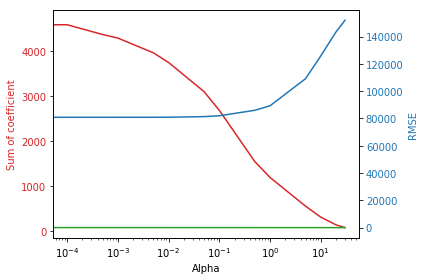

In [32]:
scores = pd.DataFrame(scores2)

fig, ax1 = plt.subplots()

plt.xscale('log')

color = 'tab:red'
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Sum of coefficient', color=color)
ax1.plot(scores[0], scores[1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
ax2.plot(scores[0], scores[3], color=color)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
ax2.plot(scores[0], scores[2], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()